In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import L1L2, L2

# (Kernel) regularization: https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t
# https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

# Adaboost:
# https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost

# Xgboost:
# https://towardsdatascience.com/cage-match-xgboost-vs-keras-deep-learning-a8bb2f69a9ab

In [2]:
# Fill empty values
def fill_empty(df):
    # Get which columns have empty values
    num_nulls = df.isnull().sum()
    has_nulls = num_nulls[num_nulls > 0].to_frame()
    
    # Get which columns potentially are numerical based on the number of values
    num_values = df[has_nulls.index].apply(lambda x: len(x.value_counts()))
    categorical_cols = num_values[num_values<=10].to_frame().index
    
    # Get the columns with outliers
    has_outliers = []

    # For each column with nulls/nas
    for col in has_nulls.index:
        # Check if there's outliers in the column
        outliers = (np.abs(stats.zscore(df[col].dropna())) >= 3).any()
        has_outliers += [outliers]
        
    # Store which columns have outliers
    has_nulls['has_outliers'] = has_outliers  
    has_nulls = has_nulls.reset_index()
    
    nulls_and_outliers = has_nulls[has_nulls.has_outliers == True]['index']
    nulls_no_outliers = has_nulls[has_nulls.has_outliers == False]['index']

    # Fill empty values appropriately (mean for non-cat., no outliers; median for non-cat., outliers; mode for cat.)
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode())
    df[nulls_no_outliers] = df[nulls_no_outliers].fillna(df[nulls_no_outliers].mean())
    df[nulls_and_outliers] = df[nulls_and_outliers].fillna(df[nulls_and_outliers].median())
#     df = df.fillna(0)
    return df, categorical_cols

In [3]:
# Load in the data
df = pd.read_csv('./train_data.csv')

print(df.target.value_counts())

# Make boolean columns into integer columns
df.replace({False: 0, True: 1}, inplace=True)

# Split the data into target labels y and features X
num_train = df.select_dtypes(include=np.number)
train_y = df.target
train_X = df.drop(['target'], axis = 1)

    
train_X, categorical_cols = fill_empty(train_X) #train_X.fillna(train_X.mean())

# Custom z-score method because scipy caused NaN problems in some columns
def z_score(arr):
    mean = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    std[std == 0] = 1
    return (arr-mean)/std

col_idx = []
for col in categorical_cols:
    col_idx.append(train_X.columns.get_loc(col))

# Normalize the data using z-score standardization
train_X = z_score(train_X.to_numpy(dtype = np.float64))
train_df = pd.DataFrame(train_X)

2    1032
1     314
0     247
Name: target, dtype: int64


In [4]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=col_idx, random_state=0, sampling_strategy = {1:450, 0:350}) # 
train_X, train_y = smote_nc.fit_resample(train_X, train_y)

In [5]:
# Turn y into categorical variable
y = to_categorical(train_y, num_classes = 3)
input_dim = train_X.shape[1]

In [6]:
from sklearn.ensemble import RandomForestClassifier

train_X = pd.DataFrame(train_X)
feature_names = [f"feature {i}" for i in range(train_X.shape[1])]
forest = RandomForestClassifier(random_state=0, criterion = 'entropy')
col_importances = forest.fit(train_X, train_y).feature_importances_

columns = train_X.columns.to_frame()
columns['importance'] = col_importances
columns.sort_values(by = 'importance', ascending = False)
important_cols_names = columns[columns.importance>=columns.importance.median()]
important_cols = important_cols_names.index
# train_df = train_X[important_cols]

train_X = train_X[important_cols].to_numpy(dtype = np.float64)

In [7]:
def create_model(input_dim, dropout = 0.5, lr = 2e-2):
    initializer = keras.initializers.HeNormal()
    regularizer = L1L2(0.01, 0.01)
    # create model
    model = Sequential()
    # Relu layers: HE15 kernel initializer
    # Maybe kernel regularization?
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_initializer = initializer, kernel_regularizer = regularizer)) 
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_initializer = initializer, kernel_regularizer = regularizer))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    # keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=lr, momentum = 0.9, nesterov=True), metrics=['accuracy'])
    return model

def avg(arr):
    return sum(arr)/len(arr)

kfold = KFold(n_splits=10, shuffle=True)

6/6 [==============================] - 0s 1ms/step - loss: 6.2867 - accuracy: 0.6141
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model\assets
6/6 [==============================] - 0s 1ms/step - loss: 2.4157 - accuracy: 0.6196
INFO:tensorflow:Assets written to: best_model\assets
6/6 [==============================] - 0s 2ms/step - loss: 2.4218 - accuracy: 0.7228
INFO:tensorflow:Assets written to: best_model\assets
6/6 [==============================] - 0s 1ms/step - loss: 2.2915 - accuracy: 0.7500
INFO:tensorflow:Assets written to: best_model\assets
6/6 [==============================] - 0s 1ms/step - loss: 2.2931 - accuracy: 0.7554
INFO:tensorflow:Assets written to: best_model\assets
6/6 [==============================] - 0s 1ms/step - loss: 1.9536 - accuracy

6/6 [==============================] - 0s 1ms/step - loss: 1.7117 - accuracy: 0.8152


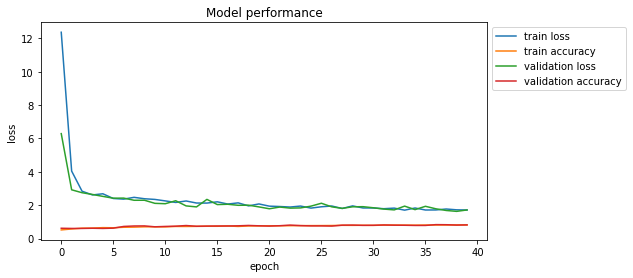

Train accuracy:			0.81	Train loss: 1.71
Validation accuracy:		0.82	Validation loss: 1.71
Best validation accuracy:	0.83 (epoch 36)


In [8]:
#https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolution-neural-network
def train_network(model, X_train, y_train, X_val, y_val, 
                  n_epochs = 10, batch_size = 32, verbose = 1, save = True, path = 'best_model'):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0
    best_epoch = 0

    # Loop over epochs
    for epoch in range(n_epochs):

        # Train model
        results = model.fit(X_train, y_train, batch_size = batch_size, verbose = verbose)

        # Get training loss and accuracy and append to lists
        train_losses.append(results.history['loss'])
        train_accs.append(results.history['accuracy'])

        # Get performance (i.e. loss and accuracy) on validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose = verbose)

        # Append to lists
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Keep track of which epoch had the best validation accuracy and store the corresponding model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            if save:
                model.save(path)

    # Visualise the performance of the model for the epochs
    if verbose > 0:
        fig = plt.figure(figsize=(8, 4))
        train_loss_plt = plt.plot(train_losses) 
        train_accs_plt = plt.plot(train_accs)
        val_loss_plt = plt.plot(val_losses)
        val_acc_plt = plt.plot(val_accs)

        # Text and legend for the plot
        plt.legend(['train loss', 'train accuracy', 'validation loss', 'validation accuracy'],
                  loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Model performance')

        plt.show()

        # Print the performance values (accuracies, loss) for train, validation
        print('Train accuracy:\t\t\t{:.2f}\tTrain loss: {:.2f}'.format(train_accs[-1][0], train_losses[-1][0]))
        print('Validation accuracy:\t\t{:.2f}\tValidation loss: {:.2f}'.format(val_accs[-1], val_losses[-1]))
        print('Best validation accuracy:\t{:.2f} (epoch {:})'.format(best_val_acc, best_epoch))

# Make a train-validation split
X_train, X_val, y_train, y_val = train_test_split(train_X, y, test_size=0.1, shuffle = True)
model = create_model(train_X.shape[1])
train_network(model, X_train, y_train, X_val, y_val, n_epochs = 40)

In [9]:
# Create prediction dataset
from tensorflow import keras
model = keras.models.load_model('best_model')
naming_cols = ['opportunity_id', 'current_date_day', 'current_date_month', 'current_date_year']
test_df = pd.read_csv('./data2tal_testupload.csv')
index_names = pd.read_csv('./check_upload_kaggle.csv')
test_df, cat_ = fill_empty(test_df)

test_df.columns = list(range(test_df.shape[1]))
test_df = test_df[important_cols]
train_X_df = pd.DataFrame(train_X)
train_X_df.columns = list(range(train_X_df.shape[1]))
test_df.columns = list(range(train_X_df.shape[1]))
test_df = test_df.fillna(-1) #train_X_df.mean()
test_df = test_df.to_numpy(dtype = np.float64)
test_X = z_score(test_df)
pred = model.predict(test_X)
print(pred)
pred_target = np.argmax(pred, axis = 1)
print(pred_target)
df_pred = pd.DataFrame([])
df_pred['index'] = index_names['index']
df_pred['target'] = pred_target

df_pred.to_csv('./prediction.csv', index = False)

[[1.82576045e-01 2.51358211e-01 5.66065788e-01]
 [5.38528375e-02 1.20191626e-01 8.25955570e-01]
 [6.13409393e-02 2.02719763e-01 7.35939324e-01]
 [1.35881118e-02 4.96896468e-02 9.36722219e-01]
 [1.67805201e-03 1.31945284e-02 9.85127389e-01]
 [3.41825653e-03 2.82512326e-02 9.68330562e-01]
 [5.09823382e-01 1.67041600e-01 3.23135078e-01]
 [9.18260887e-02 7.13120103e-02 8.36861849e-01]
 [8.00136030e-02 1.63230881e-01 7.56755531e-01]
 [1.84753798e-02 6.11611083e-02 9.20363486e-01]
 [1.30321518e-01 7.85963014e-02 7.91082203e-01]
 [4.97086912e-01 2.91035414e-01 2.11877748e-01]
 [2.63244003e-01 3.94905984e-01 3.41850042e-01]
 [1.94156036e-01 2.18387187e-01 5.87456763e-01]
 [2.80457109e-01 2.07631037e-01 5.11911869e-01]
 [2.65847653e-01 4.26018089e-01 3.08134317e-01]
 [1.09144254e-02 2.08955612e-02 9.68189955e-01]
 [5.65684540e-03 1.67926233e-02 9.77550507e-01]
 [2.43025413e-03 4.53605596e-03 9.93033648e-01]
 [1.81705087e-01 6.79259837e-01 1.39035106e-01]
 [1.66437387e-01 7.36918628e-01 9.664397

In [10]:
def get_rows_with_nulls(df):
    num_nulls = df.isna().sum()
    return num_nulls[num_nulls > 0]

test_data = pd.read_csv('./data2tal_testupload.csv')
train_data = pd.read_csv('./train_data.csv')

test_nulls = get_rows_with_nulls(test_data)
test_rows = test_data.shape[0]
fully_empty_test = list(test_nulls[test_nulls >= test_rows].index)

train_nulls = get_rows_with_nulls(train_data)
train_rows = train_data.shape[0]
mostly_empty_train = list(train_nulls[train_nulls>= train_rows/1.1].index)

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

intersect = intersection(mostly_empty_train, fully_empty_test)
print(len(intersect))

360


In [11]:
# 506     188 (filled)
# 896     188 (filled)
# 1754    188
# 1904    188
# 2202    188
# 2392    188